In [ ]:
!pip install transformers datasets unsloth accelerate bitsandbytes peft trl
!pip install tqdm matplotlib scikit-learn
!pip install sentencepiece
!pip install keras-tcn

In [ ]:


from unsloth import FastLanguageModel
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Layer, Softmax
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN
from scipy.fft import fft
from sklearn.manifold import TSNE
import torch
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from dataclasses import dataclass
from typing import List, Dict, Any
EMBEDDING_DIM = 256  # Adjusted to match CNN output
BATCH_SIZE = 16
LLM_EPOCHS = 2
LLM_BATCH_SIZE = 4
emotion_names = ["anger", "anxiety", "fear", "happiness"]
DATA_ROOT = "/kaggle/input/emgdataold/data"
FILES_PER_EMOTION = 10
SEGMENT_LENGTH = 128
NUM_FEATURES = 12
AUGMENT_NOISE_STD = 0.01
MIN_TIME_STEPS = 45000

SELECTED_EMOTIONS = ['anger', 'anxiety', 'fear', 'happiness']
MAX_SEQ_LENGTH = 2048 


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-20 08:33:41.075672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753000421.248647      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753000421.296950      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:


# Feature Extraction
def extract_features(segments):
    """Extract time- and frequency-domain features per segment across all channels."""
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)
    
    mean = np.repeat(mean, segments.shape[1], axis=1) # Repeat along time dimension
    variance = np.repeat(variance, segments.shape[1], axis=1)
    rms = np.repeat(rms, segments.shape[1], axis=1)
    mean_freq = np.repeat(mean_freq, segments.shape[1], axis=1)

    return np.concatenate([segments, mean, variance, rms, mean_freq], axis=2)

# Data Loading
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d)) and d in selected_emotions])
    
    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []
        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            try:
                emg = np.load(file_path)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    emotion_data.append(emg)
                    print(f"Loaded {file_path}: Shape {emg.shape}")
                else:
                    print(f"Invalid shape or length in {file_path}: {emg.shape}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
        else:
            print(f"No valid data for emotion: {emotion}")
    
    if not data:
        raise ValueError("No valid data loaded!")
    return data, labels, emotion_names

# Data Processing
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            print(f"Skipping sample with length {data.shape[0]} < {segment_length}")
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        print(f"Sample shape after reshape: {reshaped.shape}")
        segment_data = extract_features(reshaped)
        print(f"Sample shape after feature extraction: {segment_data.shape}")
        
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.append(segment_data + noise) # Augmented
        segments.append(segment_data)       # Original
        segment_labels.extend([label] * n_segments * 2) # Doubled labels for augmentation
    
    if not segments:
        raise ValueError("No segments created!")
    
    segments = np.concatenate(segments, axis=0)
    print(f"Concatenated segments shape: {segments.shape}")
    scaler = StandardScaler()
    reshaped_for_scaling = segments.reshape(-1, NUM_FEATURES)
    print(f"Flattened shape for scaling: {reshaped_for_scaling.shape}")
    scaled = scaler.fit_transform(reshaped_for_scaling)
    
    segments = scaled.reshape(segments.shape[0], segment_length, NUM_FEATURES)
    print(f"Final preprocessed shape: {segments.shape}")
    
    unique, counts = np.unique(segment_labels, return_counts=True)
    print("Segments per class:", dict(zip([SELECTED_EMOTIONS[i] for i in unique], counts)))
    return segments, np.array(segment_labels), scaler


Loading CNN model...


I0000 00:00:1753000445.537295      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753000445.537993      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


CNN encoder extracted successfully.
Loading data...
Loaded /kaggle/input/emgdataold/data/anger/anger_1.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_2.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_3.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_4.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_5.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_6.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_7.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_8.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_9.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anger/anger_10.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anxiety/anxiety_1.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anxiety/anxiety_2.npy: Shape (45000, 8)
Loaded /kaggle/input/emgdataold/data/anxiety/anxiety_3.npy: Sha

I0000 00:00:1753000451.508640     192 cuda_dnn.cc:529] Loaded cuDNN version 90501


351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

       anger       0.91      0.86      0.88      1404
     anxiety       0.88      0.83      0.85      1404
        fear       0.94      0.80      0.86      1404
   happiness       0.78      0.99      0.87      1404

    accuracy                           0.87      5616
   macro avg       0.88      0.87      0.87      5616
weighted avg       0.88      0.87      0.87      5616



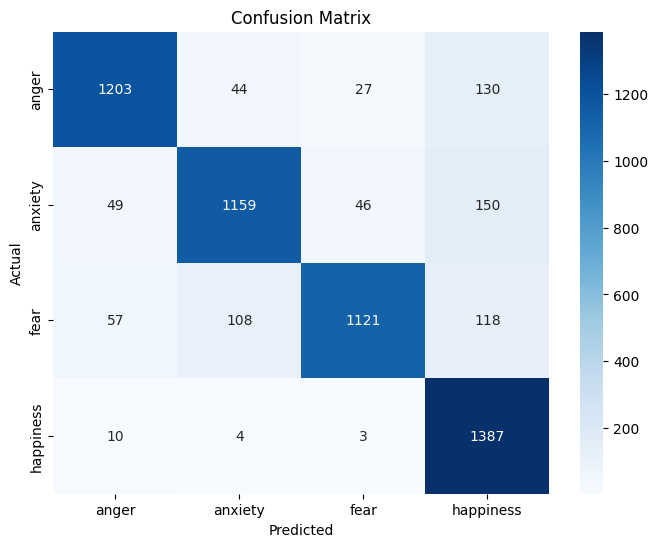

Generating CNN embeddings for visualization...


I0000 00:00:1753000453.651920     193 service.cc:148] XLA service 0x7f55782183e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753000453.652741     193 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753000453.652765     193 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 95/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1753000454.240768     193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


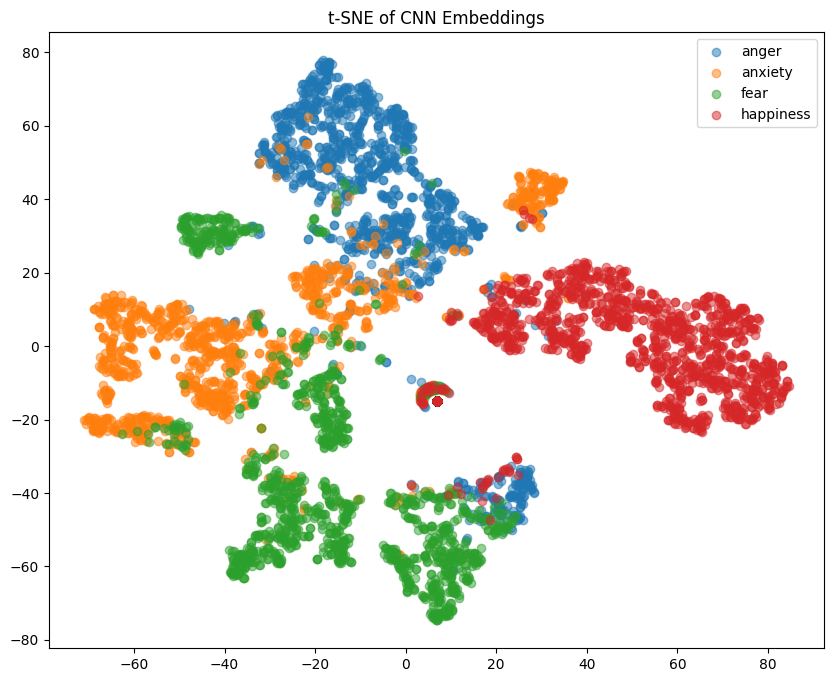

Visualizing feature distributions...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

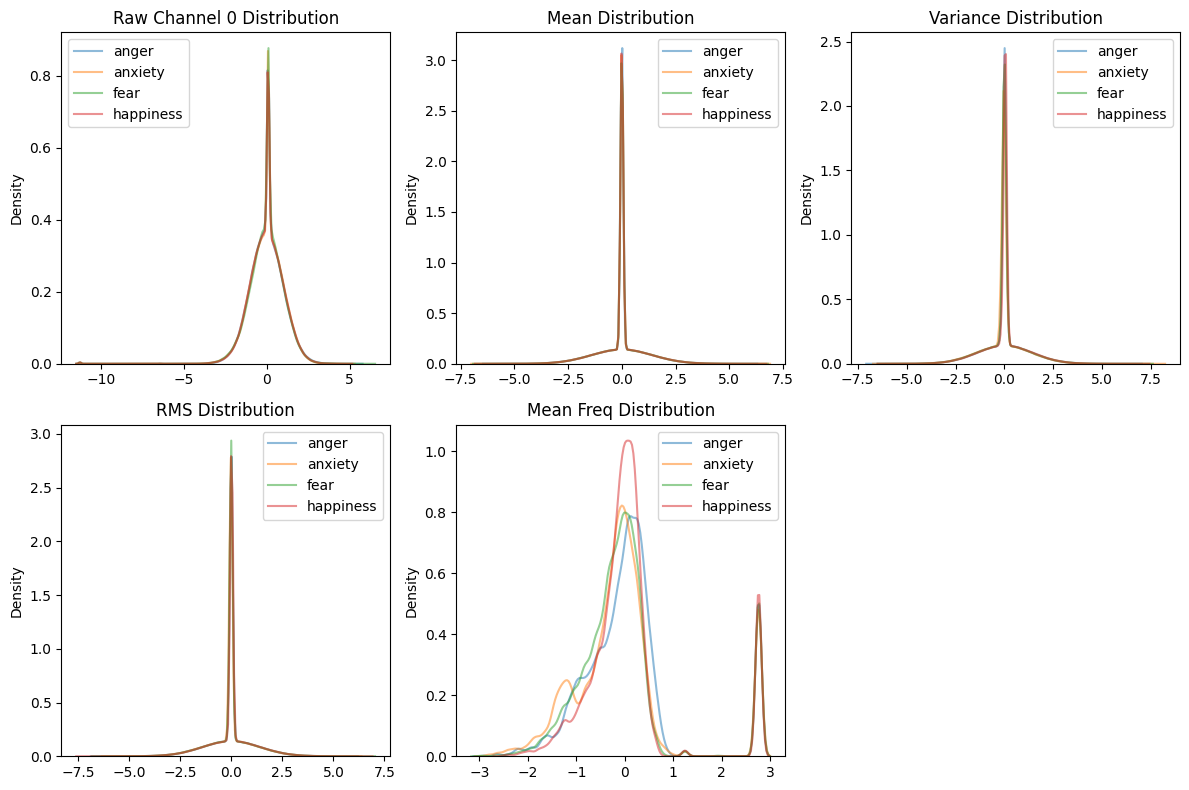

In [ ]:

# Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        pt = tf.where(y_true_one_hot == 1, y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

    
# Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.dense = Dense(1, activation='tanh', name='dense_1')
        self.dense.build(input_shape)  # Explicitly build the Dense layer
        self.softmax = Softmax(axis=1)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention = self.dense(inputs)
        attention = self.softmax(attention)
        weighted = inputs * attention
        return tf.reduce_sum(weighted, axis=1)  # [batch, nb_filters]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

    def build_from_config(self, config):
        # Ensure the layer is rebuilt correctly during deserialization
        super(AttentionLayer, self).build_from_config(config)

    @classmethod
    def from_config(cls, config):
        return cls(**config)
# Feature Extraction
def extract_features(segments):
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)
    
    mean = np.repeat(mean, segments.shape[1], axis=1) # Repeat along time dimension
    variance = np.repeat(variance, segments.shape[1], axis=1)
    rms = np.repeat(rms, segments.shape[1], axis=1)
    mean_freq = np.repeat(mean_freq, segments.shape[1], axis=1)

    return np.concatenate([segments, mean, variance, rms, mean_freq], axis=2)

# Data Loading
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d)) and d in selected_emotions])
    
    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []
        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            try:
                emg = np.load(file_path)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    # Pad or truncate to MIN_TIME_STEPS
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        # Pad with zeros
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    emotion_data.append(emg)
                    print(f"Loaded {file_path}: Shape {emg.shape}")
                else:
                    
                    print(f"Invalid shape or length in {file_path}: {emg.shape}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
        else:
            print(f"No valid data for emotion: {emotion}")
    
    if not data:
        raise ValueError("No valid data loaded!")
    return data, labels, emotion_names

# Data Processing
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            print(f"Skipping sample with length {data.shape[0]} < {segment_length}")
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        print(f"Sample shape after reshape: {reshaped.shape}")
        segment_data = extract_features(reshaped)
        print(f"Sample shape after feature extraction: {segment_data.shape}")
        
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.append(segment_data + noise) # Augmented
        segments.append(segment_data)       # Original
        segment_labels.extend([label] * n_segments * 2) # Doubled labels for augmentation
    
    if not segments:
        raise ValueError("No segments created!")
    
    segments = np.concatenate(segments, axis=0)
    print(f"Concatenated segments shape: {segments.shape}")
    scaler = StandardScaler()
    reshaped_for_scaling = segments.reshape(-1, NUM_FEATURES)
    print(f"Flattened shape for scaling: {reshaped_for_scaling.shape}")
    scaled = scaler.fit_transform(reshaped_for_scaling)
    
    segments = scaled.reshape(segments.shape[0], segment_length, NUM_FEATURES)
    print(f"Final preprocessed shape: {segments.shape}")
    
    unique, counts = np.unique(segment_labels, return_counts=True)
    print("Segments per class:", dict(zip([SELECTED_EMOTIONS[i] for i in unique], counts)))
    return segments, np.array(segment_labels), scaler

# Visualizing Functions
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_distributions(segments, labels, emotion_names):
    plt.figure(figsize=(12, 8))
    feature_indices_to_plot = [0, 8, 9, 10, 11] # Raw channel 0, Mean, Variance, RMS, Mean Freq
    feature_names_to_plot = ["Raw Channel 0", "Mean", "Variance", "RMS", "Mean Freq"]
    
    for i, feature_idx in enumerate(feature_indices_to_plot):
        plt.subplot(2, 3, i + 1) # Arrange in 2 rows, 3 columns
        for j, name in enumerate(emotion_names):
            mask = labels == j
            # Flatten across the time dimension for distribution plot
            feature_values = segments[mask, :, feature_idx].flatten()
            sns.kdeplot(feature_values, label=name, alpha=0.5)
        plt.title(f"{feature_names_to_plot[i]} Distribution")
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_embeddings(embeddings, labels, emotion_names):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    if embeddings.ndim > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1) # Flatten if CNN output is (batch, seq, dim)
    
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(emotion_names):
        mask = labels == i
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], label=name, alpha=0.5)
    plt.legend()
    plt.title("t-SNE of CNN Embeddings")
    plt.show()


# Load CNN model
print("Loading CNN model...")
try:
    model_path = "/kaggle/input/emotion_cnn_model.keras/keras/default/1/emotion_cnn_model.keras"
    cnn_model = load_model(
        model_path,
        custom_objects={
            "focal_loss_fn": focal_loss(gamma=2.0, alpha=0.25),
            "AttentionLayer": AttentionLayer
        }
    )
    cnn_encoder = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer("segment_embedding").output)
    print("CNN encoder extracted successfully.")
except Exception as e:
    print(f"Failed to load CNN model: {e}")
    raise

# Load and Process Data
print("Loading data...")
data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, emotion_names)
print(f"Loaded {len(data_list)} files, {len(emotion_names)} emotions: {emotion_names}")

print("Preprocessing data...")
segments, segment_labels, scaler = preprocess_data(data_list, labels, SEGMENT_LENGTH)

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Validate CNN model
print("Validating CNN model...")
y_pred = np.argmax(cnn_model.predict(X_test, batch_size=BATCH_SIZE), axis=1)
print(classification_report(y_test, y_pred, target_names=emotion_names))
plot_confusion_matrix(y_test, y_pred, emotion_names)

print("Generating CNN embeddings for visualization...")
embeddings = cnn_encoder.predict(X_test, batch_size=BATCH_SIZE)
plot_embeddings(embeddings, y_test, emotion_names)


print("Visualizing feature distributions...")
plot_feature_distributions(segments, segment_labels, emotion_names)

# -----------------------------------------------------
## MultiModalLLM Class
class MultiModalLLM(torch.nn.Module):
    def __init__(self, llm_model, emg_embedding_dim):
        super().__init__()
        self.llm = llm_model
        self.llm_embedding_dim = self.llm.config.hidden_size 
        
        self.emg_projection = torch.nn.Linear(emg_embedding_dim, self.llm_embedding_dim)

    def forward(self, input_ids, attention_mask, emg_embeddings=None, labels=None):
        text_embeddings = self.llm.get_input_embeddings()(input_ids) # (batch_size, seq_len, llm_embedding_dim)
        
        if emg_embeddings is not None:
            emg_embeddings_reshaped = emg_embeddings.unsqueeze(1) 
            projected_emg = self.emg_projection(emg_embeddings_reshaped) # (batch_size, 1, llm_embedding_dim)
            
            combined_embeddings = torch.cat((projected_emg, text_embeddings), dim=1)
            emg_attention_mask = torch.ones(projected_emg.shape[0], 1, dtype=attention_mask.dtype, device=attention_mask.device)
            combined_attention_mask = torch.cat((emg_attention_mask, attention_mask), dim=1)
        else:
            combined_embeddings = text_embeddings
            combined_attention_mask = attention_mask
        
        output = self.llm(
            inputs_embeds=combined_embeddings,
            attention_mask=combined_attention_mask,
            labels=labels, # Pass labels through for loss calculation
            return_dict=True,
        )
        return output

    def __getattr__(self, name):
        """Delegates attribute lookup to the underlying LLM model if not found on MultiModalLLM."""
        try:
            return super().__getattr__(name) # Try to get attribute from own class/inherited methods
        except AttributeError:
            if hasattr(self.llm, name): # If not found, check the inner LLM
                return getattr(self.llm, name)
            raise # If still not found, raise AttributeError


In [ ]:

class CustomDataCollator:
    def __init__(self, tokenizer, max_seq_length, llm_embedding_dim):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.llm_embedding_dim = llm_embedding_dim

    def __call__(self, features):
        input_ids = [f["input_ids"] for f in features]
        attention_mask = [f["attention_mask"] for f in features]
        labels = [f["labels"] for f in features]
        
        # Pad sequences
        input_ids = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(ids, dtype=torch.long) for ids in input_ids], 
            batch_first=True, 
            padding_value=self.tokenizer.pad_token_id
        )
        attention_mask = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(mask, dtype=torch.long) for mask in attention_mask], 
            batch_first=True, 
            padding_value=0
        )
        labels = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(lbl, dtype=torch.long) for lbl in labels], 
            batch_first=True, 
            padding_value=-100
        )
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

def prepare_llm_dataset(embeddings, labels, emotion_names, tokenizer):
    data = [
        {
            "input_ids": tokenizer(f"Emotion: {emotion_names[label]}", return_tensors="pt")["input_ids"].squeeze().tolist(),
            "attention_mask": tokenizer(f"Emotion: {emotion_names[label]}", return_tensors="pt")["attention_mask"].squeeze().tolist(),
            "labels": tokenizer(f"Emotion: {emotion_names[label]}", return_tensors="pt")["input_ids"].squeeze().tolist()
        }
        for embedding, label in zip(embeddings, labels)
    ]
    # Convert to Hugging Face Dataset
    return Dataset.from_list(data)
# LLM FineTuning Function
def fine_tune_llm(model, tokenizer, dataset, data_collator, output_dir="./llm_finetuned"):
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=LLM_EPOCHS,
        per_device_train_batch_size=LLM_BATCH_SIZE,
        per_device_eval_batch_size=LLM_BATCH_SIZE,
        gradient_accumulation_steps=4,
        gradient_checkpointing=True,
        fp16=True,
        learning_rate=1e-4,  
        lr_scheduler_type="cosine",  
        warmup_ratio=0.1,  
        weight_decay=0.01,
        save_strategy="steps",
        save_steps=100,
        save_total_limit=2,
        eval_strategy="steps",
        eval_steps=50,
        logging_dir="logs",
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2,  
        remove_unused_columns=False,
        seed=42,
        dataloader_pin_memory=True,
        save_safetensors=True,
        optim="adamw_torch_fused", 
        push_to_hub=False
    )
        

    eval_size = max(1, int(0.2 * len(dataset)))
    eval_dataset = dataset.select(range(eval_size))

    trainer = Trainer(
        model=model,  # Use the PEFT-enabled model directly
        args=training_args,
        train_dataset=dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )

    trainer.train()
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading LLM for fine-tuning...")
llm_base_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/tinyllama-bnb-4bit",
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=None,  # Auto selects float16
    load_in_4bit=True,
    device_map={"": 0}  # Force to cuda:0
)
llm_peft_model = FastLanguageModel.get_peft_model(
    llm_base_model,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    use_gradient_checkpointing="unsloth",
    random_state=42,
    max_seq_length=MAX_SEQ_LENGTH
)
llm_peft_model = FastLanguageModel.for_training(llm_peft_model)

print("Generating TCN embeddings for LLM training...")
train_embeddings = cnn_encoder.predict(X_train, batch_size=BATCH_SIZE)

print("Preparing LLM dataset...")
llm_dataset = prepare_llm_dataset(train_embeddings, y_train, emotion_names, tokenizer)
print(f"LLM dataset size: {len(llm_dataset)}")

llm_embedding_dim = llm_base_model.config.hidden_size
data_collator = CustomDataCollator(tokenizer, MAX_SEQ_LENGTH, llm_embedding_dim)

print("Fine-tuning LLM with LoRA...")
try:
    fine_tune_llm(llm_peft_model, tokenizer, llm_dataset, data_collator)
except Exception as e:
    print(f"LLM fine-tuning failed: {e}")
    raise

model_to_train = MultiModalLLM(llm_peft_model, EMBEDDING_DIM)
model_to_train.to(device)


Using device: cuda:0
Loading LLM for fine-tuning...
==((====))==  Unsloth 2025.7.5: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/762M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.7.5 patched 22 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Generating TCN embeddings for LLM training...
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Preparing LLM dataset...
LLM dataset size: 17971
Fine-tuning LLM with LoRA...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 17,971 | Num Epochs = 2 | Total steps = 1,124
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 12,615,680 of 1,112,664,064 (1.13% trained)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALL

Step,Training Loss,Validation Loss
50,7.970500,8.079829
100,8.030900,8.078998
150,7.980800,8.073148
200,8.066100,8.075839
250,8.045900,8.075665
300,8.068800,8.073003
350,8.100500,8.070272
400,8.049700,8.073713
450,8.062400,8.071606
500,8.036400,8.075047


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism 

MultiModalLLM(
  (llm): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): LlamaForCausalLM(
        (model): LlamaModel(
          (embed_tokens): Embedding(32000, 2048, padding_idx=0)
          (layers): ModuleList(
            (0-21): 22 x LlamaDecoderLayer(
              (self_attn): LlamaAttention(
                (q_proj): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=2048, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=2048, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                  (lora_embedding_B): ParameterDict()
                  (l

In [ ]:
#EVALUATION

In [9]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import random
import pandas as pd

def evaluate_and_display_predictions(model, cnn_encoder, X_test, y_test, emotion_names, tokenizer, device,
                                     prompt_template="The emotion is class {}", display=50, batch_size=16, max_seq_length=128):
    model.eval()
    results = []
    correct = 0

    # Prepare pseudo texts (so we can format prompts)
    pseudo_texts = [f"sample {i}" for i in range(len(X_test))]  # dummy text placeholders
    val_df = pd.DataFrame({"text": pseudo_texts, "label": y_test})

    # Sort by "text length" just to match your original format (not needed here, but harmless)
    val_df["token_length"] = val_df["text"].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
    val_df_sorted = val_df.sort_values(by='token_length').reset_index(drop=True)

    with torch.inference_mode():
        for i in tqdm(range(0, len(val_df_sorted), batch_size), desc="Evaluating"):
            batch = val_df_sorted.iloc[i:i + batch_size]
            batch_embeds = cnn_encoder.predict(X_test[batch.index], batch_size=batch_size)

            emg_tensor = torch.tensor(batch_embeds, dtype=torch.float32).to(device)
            attention_mask = torch.ones((emg_tensor.size(0), 1), dtype=torch.long).to(device)

            # Create dummy input_ids for compatibility
            input_ids = torch.zeros((emg_tensor.size(0), 1), dtype=torch.long).to(device)

            # Get logits from the LLM
            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                emg_embeddings=emg_tensor
            )

            logits = output.logits[:, -1, :]  # shape: [batch, vocab_size]

            # Find token IDs corresponding to emotion names
            emotion_token_ids = [tokenizer.encode(name, add_special_tokens=False)[0] for name in emotion_names]
            probs_all = F.softmax(logits, dim=-1)
            probs = probs_all[:, emotion_token_ids]  # [batch_size, num_emotions]

            preds = torch.argmax(probs, dim=-1).cpu().numpy()
            true_labels = batch["label"].tolist()

            correct += sum(p == t for p, t in zip(preds, true_labels))

            for j in range(len(batch)):
                results.append({
                    "text": batch['text'].iloc[j],
                    "true": true_labels[j],
                    "pred": preds[j],
                    "probs": probs[j].cpu().numpy(),
                    "ok": preds[j] == true_labels[j]
                })

    accuracy = 100 * correct / len(val_df_sorted)
    print(f"\n✅ Validation Accuracy: {accuracy:.2f}% ({correct}/{len(val_df_sorted)})")

    print("\n --- Random Samples ---")
    for s in random.sample(results, min(display, len(results))):
        print(f"\nText: {s['text']}")
        print(f"True: {emotion_names[s['true']]} | Pred: {emotion_names[s['pred']]} {'✅' if s['ok'] else '❌'}")
        print("Probs:", ", ".join([f"{emotion_names[k]}: {v:.3f}" for k, v in enumerate(s['probs'])]))

    # Optional: return predictions for further analysis
    return results


In [10]:
results = evaluate_and_display_predictions(
    model=model_to_train,
    cnn_encoder=cnn_encoder,
    X_test=X_test,
    y_test=y_test,
    emotion_names=emotion_names,
    tokenizer=tokenizer,
    device=device,
    display=20,  # number of random samples to print
    batch_size=16,
    max_seq_length=MAX_SEQ_LENGTH
)


Evaluating:   0%|          | 0/351 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:   0%|          | 1/351 [00:00<01:29,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   1%|          | 2/351 [00:00<01:13,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   1%|          | 3/351 [00:00<01:07,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   1%|          | 4/351 [00:00<01:05,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   1%|▏         | 5/351 [00:00<01:04,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   2%|▏         | 6/351 [00:01<01:03,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   2%|▏         | 7/351 [00:01<01:02,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   2%|▏         | 8/351 [00:01<01:01,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   3%|▎         | 9/351 [00:01<01:01,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   3%|▎         | 10/351 [00:01<01:01,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   3%|▎         | 11/351 [00:02<01:01,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   3%|▎         | 12/351 [00:02<01:00,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   4%|▎         | 13/351 [00:02<01:00,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   4%|▍         | 14/351 [00:02<00:59,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   4%|▍         | 15/351 [00:02<00:59,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   5%|▍         | 16/351 [00:02<00:59,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   5%|▍         | 17/351 [00:03<00:59,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   5%|▌         | 18/351 [00:03<00:59,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:   5%|▌         | 19/351 [00:03<01:00,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   6%|▌         | 20/351 [00:03<00:59,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   6%|▌         | 21/351 [00:03<00:59,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   6%|▋         | 22/351 [00:04<00:58,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:   7%|▋         | 23/351 [00:04<00:58,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   7%|▋         | 24/351 [00:04<00:58,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   7%|▋         | 25/351 [00:04<00:58,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:   7%|▋         | 26/351 [00:04<00:58,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:   8%|▊         | 27/351 [00:04<01:00,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   8%|▊         | 28/351 [00:05<00:59,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   8%|▊         | 29/351 [00:05<00:58,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   9%|▊         | 30/351 [00:05<00:58,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   9%|▉         | 31/351 [00:05<00:58,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:   9%|▉         | 32/351 [00:05<00:58,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:   9%|▉         | 33/351 [00:06<00:57,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  10%|▉         | 34/351 [00:06<00:57,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  10%|▉         | 35/351 [00:06<00:56,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  10%|█         | 36/351 [00:06<00:56,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  11%|█         | 37/351 [00:06<00:56,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  11%|█         | 38/351 [00:06<00:56,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  11%|█         | 39/351 [00:07<00:55,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  11%|█▏        | 40/351 [00:07<00:56,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  12%|█▏        | 41/351 [00:07<00:56,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  12%|█▏        | 42/351 [00:07<00:55,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  12%|█▏        | 43/351 [00:07<00:55,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  13%|█▎        | 44/351 [00:07<00:55,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  13%|█▎        | 45/351 [00:08<00:54,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  13%|█▎        | 46/351 [00:08<00:54,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  13%|█▎        | 47/351 [00:08<00:54,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  14%|█▎        | 48/351 [00:08<00:54,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  14%|█▍        | 49/351 [00:08<00:54,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  14%|█▍        | 50/351 [00:09<00:53,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  15%|█▍        | 51/351 [00:09<00:53,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  15%|█▍        | 52/351 [00:09<00:53,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  15%|█▌        | 53/351 [00:09<00:53,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  15%|█▌        | 54/351 [00:09<00:52,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  16%|█▌        | 55/351 [00:09<00:52,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  16%|█▌        | 56/351 [00:10<00:52,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  16%|█▌        | 57/351 [00:10<00:52,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  17%|█▋        | 58/351 [00:10<00:51,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  17%|█▋        | 59/351 [00:10<00:52,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  17%|█▋        | 60/351 [00:10<00:52,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  17%|█▋        | 61/351 [00:11<00:52,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  18%|█▊        | 62/351 [00:11<00:52,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  18%|█▊        | 63/351 [00:11<00:51,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  18%|█▊        | 64/351 [00:11<00:51,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  19%|█▊        | 65/351 [00:11<00:53,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  19%|█▉        | 66/351 [00:11<00:52,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  19%|█▉        | 67/351 [00:12<00:52,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  19%|█▉        | 68/351 [00:12<00:51,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  20%|█▉        | 69/351 [00:12<00:51,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  20%|█▉        | 70/351 [00:12<00:50,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  20%|██        | 71/351 [00:12<00:50,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  21%|██        | 72/351 [00:13<00:50,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  21%|██        | 73/351 [00:13<00:49,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  21%|██        | 74/351 [00:13<00:49,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  21%|██▏       | 75/351 [00:13<00:49,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  22%|██▏       | 76/351 [00:13<00:49,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  22%|██▏       | 77/351 [00:13<00:48,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  22%|██▏       | 78/351 [00:14<00:48,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  23%|██▎       | 79/351 [00:14<00:48,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  23%|██▎       | 80/351 [00:14<00:48,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  23%|██▎       | 81/351 [00:14<00:48,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  23%|██▎       | 82/351 [00:14<00:50,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  24%|██▎       | 83/351 [00:15<00:49,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  24%|██▍       | 84/351 [00:15<00:48,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  24%|██▍       | 85/351 [00:15<00:48,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  25%|██▍       | 86/351 [00:15<00:47,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  25%|██▍       | 87/351 [00:15<00:47,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  25%|██▌       | 88/351 [00:15<00:47,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  25%|██▌       | 89/351 [00:16<00:47,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  26%|██▌       | 90/351 [00:16<00:47,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  26%|██▌       | 91/351 [00:16<00:47,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  26%|██▌       | 92/351 [00:16<00:47,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  26%|██▋       | 93/351 [00:16<00:46,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  27%|██▋       | 94/351 [00:17<00:46,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  27%|██▋       | 95/351 [00:17<00:46,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  27%|██▋       | 96/351 [00:17<00:47,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  28%|██▊       | 97/351 [00:17<00:46,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  28%|██▊       | 98/351 [00:17<00:48,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  28%|██▊       | 99/351 [00:17<00:49,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  28%|██▊       | 100/351 [00:18<00:48,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  29%|██▉       | 101/351 [00:18<00:47,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  29%|██▉       | 102/351 [00:18<00:46,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  29%|██▉       | 103/351 [00:18<00:46,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  30%|██▉       | 104/351 [00:18<00:46,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  30%|██▉       | 105/351 [00:19<00:46,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  30%|███       | 106/351 [00:19<00:45,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  30%|███       | 107/351 [00:19<00:44,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  31%|███       | 108/351 [00:19<00:44,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  31%|███       | 109/351 [00:19<00:43,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  31%|███▏      | 110/351 [00:19<00:43,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  32%|███▏      | 111/351 [00:20<00:42,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  32%|███▏      | 112/351 [00:20<00:42,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  32%|███▏      | 113/351 [00:20<00:42,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  32%|███▏      | 114/351 [00:20<00:42,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  33%|███▎      | 115/351 [00:20<00:42,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  33%|███▎      | 116/351 [00:21<00:42,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  33%|███▎      | 117/351 [00:21<00:41,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  34%|███▎      | 118/351 [00:21<00:41,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  34%|███▍      | 119/351 [00:21<00:41,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  34%|███▍      | 120/351 [00:21<00:41,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  34%|███▍      | 121/351 [00:21<00:41,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  35%|███▍      | 122/351 [00:22<00:41,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  35%|███▌      | 123/351 [00:22<00:41,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  35%|███▌      | 124/351 [00:22<00:41,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  36%|███▌      | 125/351 [00:22<00:40,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  36%|███▌      | 126/351 [00:22<00:40,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  36%|███▌      | 127/351 [00:23<00:41,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  36%|███▋      | 128/351 [00:23<00:40,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  37%|███▋      | 129/351 [00:23<00:40,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  37%|███▋      | 130/351 [00:23<00:40,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  37%|███▋      | 131/351 [00:23<00:39,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  38%|███▊      | 132/351 [00:23<00:39,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  38%|███▊      | 133/351 [00:24<00:39,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  38%|███▊      | 134/351 [00:24<00:38,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  38%|███▊      | 135/351 [00:24<00:38,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  39%|███▊      | 136/351 [00:24<00:38,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  39%|███▉      | 137/351 [00:24<00:39,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  39%|███▉      | 138/351 [00:25<00:39,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  40%|███▉      | 139/351 [00:25<00:38,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  40%|███▉      | 140/351 [00:25<00:38,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  40%|████      | 141/351 [00:25<00:38,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  40%|████      | 142/351 [00:25<00:37,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  41%|████      | 143/351 [00:25<00:37,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  41%|████      | 144/351 [00:26<00:37,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  41%|████▏     | 145/351 [00:26<00:36,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  42%|████▏     | 146/351 [00:26<00:36,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  42%|████▏     | 147/351 [00:26<00:36,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  42%|████▏     | 148/351 [00:26<00:36,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  42%|████▏     | 149/351 [00:27<00:36,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  43%|████▎     | 150/351 [00:27<00:35,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  43%|████▎     | 151/351 [00:27<00:35,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  43%|████▎     | 152/351 [00:27<00:35,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  44%|████▎     | 153/351 [00:27<00:35,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  44%|████▍     | 154/351 [00:27<00:35,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  44%|████▍     | 155/351 [00:28<00:35,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  44%|████▍     | 156/351 [00:28<00:35,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  45%|████▍     | 157/351 [00:28<00:34,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  45%|████▌     | 158/351 [00:28<00:34,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  45%|████▌     | 159/351 [00:28<00:34,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  46%|████▌     | 160/351 [00:29<00:34,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  46%|████▌     | 161/351 [00:29<00:35,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  46%|████▌     | 162/351 [00:29<00:35,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  46%|████▋     | 163/351 [00:29<00:34,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  47%|████▋     | 164/351 [00:29<00:34,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  47%|████▋     | 165/351 [00:29<00:34,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  47%|████▋     | 166/351 [00:30<00:34,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  48%|████▊     | 167/351 [00:30<00:33,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  48%|████▊     | 168/351 [00:30<00:33,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  48%|████▊     | 169/351 [00:30<00:32,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  48%|████▊     | 170/351 [00:30<00:32,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  49%|████▊     | 171/351 [00:31<00:32,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  49%|████▉     | 172/351 [00:31<00:32,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  49%|████▉     | 173/351 [00:31<00:32,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  50%|████▉     | 174/351 [00:31<00:32,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  50%|████▉     | 175/351 [00:31<00:32,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  50%|█████     | 176/351 [00:31<00:31,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  50%|█████     | 177/351 [00:32<00:31,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  51%|█████     | 178/351 [00:32<00:31,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  51%|█████     | 179/351 [00:32<00:30,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  51%|█████▏    | 180/351 [00:32<00:30,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  52%|█████▏    | 181/351 [00:32<00:30,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  52%|█████▏    | 182/351 [00:33<00:30,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  52%|█████▏    | 183/351 [00:33<00:29,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  52%|█████▏    | 184/351 [00:33<00:29,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  53%|█████▎    | 185/351 [00:33<00:29,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  53%|█████▎    | 186/351 [00:33<00:29,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  53%|█████▎    | 187/351 [00:33<00:29,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  54%|█████▎    | 188/351 [00:34<00:29,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  54%|█████▍    | 189/351 [00:34<00:28,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  54%|█████▍    | 190/351 [00:34<00:28,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  54%|█████▍    | 191/351 [00:34<00:28,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  55%|█████▍    | 192/351 [00:34<00:30,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  55%|█████▍    | 193/351 [00:35<00:29,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  55%|█████▌    | 194/351 [00:35<00:29,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  56%|█████▌    | 195/351 [00:35<00:28,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  56%|█████▌    | 196/351 [00:35<00:27,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  56%|█████▌    | 197/351 [00:35<00:27,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  56%|█████▋    | 198/351 [00:35<00:27,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  57%|█████▋    | 199/351 [00:36<00:27,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  57%|█████▋    | 200/351 [00:36<00:27,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  57%|█████▋    | 201/351 [00:36<00:27,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  58%|█████▊    | 202/351 [00:36<00:26,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  58%|█████▊    | 203/351 [00:36<00:26,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  58%|█████▊    | 204/351 [00:36<00:26,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  58%|█████▊    | 205/351 [00:37<00:26,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  59%|█████▊    | 206/351 [00:37<00:26,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  59%|█████▉    | 207/351 [00:37<00:25,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  59%|█████▉    | 208/351 [00:37<00:25,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  60%|█████▉    | 209/351 [00:37<00:25,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  60%|█████▉    | 210/351 [00:38<00:25,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  60%|██████    | 211/351 [00:38<00:24,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  60%|██████    | 212/351 [00:38<00:24,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  61%|██████    | 213/351 [00:38<00:24,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  61%|██████    | 214/351 [00:38<00:24,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  61%|██████▏   | 215/351 [00:38<00:24,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  62%|██████▏   | 216/351 [00:39<00:24,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  62%|██████▏   | 217/351 [00:39<00:23,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  62%|██████▏   | 218/351 [00:39<00:23,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  62%|██████▏   | 219/351 [00:39<00:23,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  63%|██████▎   | 220/351 [00:39<00:23,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  63%|██████▎   | 221/351 [00:40<00:23,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  63%|██████▎   | 222/351 [00:40<00:23,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  64%|██████▎   | 223/351 [00:40<00:22,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  64%|██████▍   | 224/351 [00:40<00:22,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  64%|██████▍   | 225/351 [00:40<00:22,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  64%|██████▍   | 226/351 [00:40<00:22,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  65%|██████▍   | 227/351 [00:41<00:22,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  65%|██████▍   | 228/351 [00:41<00:21,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  65%|██████▌   | 229/351 [00:41<00:21,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  66%|██████▌   | 230/351 [00:41<00:21,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Evaluating:  66%|██████▌   | 231/351 [00:41<00:21,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  66%|██████▌   | 232/351 [00:42<00:21,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  66%|██████▋   | 233/351 [00:42<00:21,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  67%|██████▋   | 234/351 [00:42<00:21,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  67%|██████▋   | 235/351 [00:42<00:21,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  67%|██████▋   | 236/351 [00:42<00:21,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  68%|██████▊   | 237/351 [00:42<00:20,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  68%|██████▊   | 238/351 [00:43<00:20,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  68%|██████▊   | 239/351 [00:43<00:20,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  68%|██████▊   | 240/351 [00:43<00:19,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  69%|██████▊   | 241/351 [00:43<00:19,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  69%|██████▉   | 242/351 [00:43<00:19,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  69%|██████▉   | 243/351 [00:43<00:19,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  70%|██████▉   | 244/351 [00:44<00:19,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  70%|██████▉   | 245/351 [00:44<00:18,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  70%|███████   | 246/351 [00:44<00:18,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  70%|███████   | 247/351 [00:44<00:18,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  71%|███████   | 248/351 [00:44<00:19,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  71%|███████   | 249/351 [00:45<00:18,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  71%|███████   | 250/351 [00:45<00:18,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  72%|███████▏  | 251/351 [00:45<00:17,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  72%|███████▏  | 252/351 [00:45<00:17,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  72%|███████▏  | 253/351 [00:45<00:17,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  72%|███████▏  | 254/351 [00:45<00:17,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  73%|███████▎  | 255/351 [00:46<00:17,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  73%|███████▎  | 256/351 [00:46<00:16,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  73%|███████▎  | 257/351 [00:46<00:16,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  74%|███████▎  | 258/351 [00:46<00:16,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  74%|███████▍  | 259/351 [00:46<00:16,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  74%|███████▍  | 260/351 [00:47<00:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  74%|███████▍  | 261/351 [00:47<00:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  75%|███████▍  | 262/351 [00:47<00:16,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  75%|███████▍  | 263/351 [00:47<00:15,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  75%|███████▌  | 264/351 [00:47<00:15,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  75%|███████▌  | 265/351 [00:47<00:15,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  76%|███████▌  | 266/351 [00:48<00:15,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  76%|███████▌  | 267/351 [00:48<00:15,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  76%|███████▋  | 268/351 [00:48<00:14,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  77%|███████▋  | 269/351 [00:48<00:14,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  77%|███████▋  | 270/351 [00:48<00:14,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  77%|███████▋  | 271/351 [00:49<00:14,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Evaluating:  77%|███████▋  | 272/351 [00:49<00:14,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Evaluating:  78%|███████▊  | 273/351 [00:49<00:14,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  78%|███████▊  | 274/351 [00:49<00:15,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  78%|███████▊  | 275/351 [00:49<00:14,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  79%|███████▊  | 276/351 [00:50<00:14,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  79%|███████▉  | 277/351 [00:50<00:13,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  79%|███████▉  | 278/351 [00:50<00:13,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  79%|███████▉  | 279/351 [00:50<00:13,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  80%|███████▉  | 280/351 [00:50<00:12,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  80%|████████  | 281/351 [00:50<00:12,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  80%|████████  | 282/351 [00:51<00:12,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  81%|████████  | 283/351 [00:51<00:12,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  81%|████████  | 284/351 [00:51<00:12,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  81%|████████  | 285/351 [00:51<00:11,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  81%|████████▏ | 286/351 [00:51<00:11,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  82%|████████▏ | 287/351 [00:52<00:11,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  82%|████████▏ | 288/351 [00:52<00:11,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  82%|████████▏ | 289/351 [00:52<00:11,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  83%|████████▎ | 290/351 [00:52<00:11,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  83%|████████▎ | 291/351 [00:52<00:10,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  83%|████████▎ | 292/351 [00:52<00:10,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  83%|████████▎ | 293/351 [00:53<00:10,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  84%|████████▍ | 294/351 [00:53<00:10,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  84%|████████▍ | 295/351 [00:53<00:10,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  84%|████████▍ | 296/351 [00:53<00:09,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  85%|████████▍ | 297/351 [00:53<00:09,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  85%|████████▍ | 298/351 [00:53<00:09,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  85%|████████▌ | 299/351 [00:54<00:09,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  85%|████████▌ | 300/351 [00:54<00:09,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  86%|████████▌ | 301/351 [00:54<00:09,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  86%|████████▌ | 302/351 [00:54<00:08,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  86%|████████▋ | 303/351 [00:54<00:09,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  87%|████████▋ | 304/351 [00:55<00:08,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  87%|████████▋ | 305/351 [00:55<00:08,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  87%|████████▋ | 306/351 [00:55<00:08,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  87%|████████▋ | 307/351 [00:55<00:08,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  88%|████████▊ | 308/351 [00:55<00:07,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  88%|████████▊ | 309/351 [00:56<00:07,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  88%|████████▊ | 310/351 [00:56<00:07,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  89%|████████▊ | 311/351 [00:56<00:07,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  89%|████████▉ | 312/351 [00:56<00:07,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  89%|████████▉ | 313/351 [00:56<00:06,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  89%|████████▉ | 314/351 [00:56<00:06,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  90%|████████▉ | 315/351 [00:57<00:06,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  90%|█████████ | 316/351 [00:57<00:06,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  90%|█████████ | 317/351 [00:57<00:06,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  91%|█████████ | 318/351 [00:57<00:05,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  91%|█████████ | 319/351 [00:57<00:05,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  91%|█████████ | 320/351 [00:57<00:05,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  91%|█████████▏| 321/351 [00:58<00:05,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  92%|█████████▏| 322/351 [00:58<00:05,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  92%|█████████▏| 323/351 [00:58<00:04,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  92%|█████████▏| 324/351 [00:58<00:04,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  93%|█████████▎| 325/351 [00:58<00:04,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  93%|█████████▎| 326/351 [00:59<00:04,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  93%|█████████▎| 327/351 [00:59<00:04,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  93%|█████████▎| 328/351 [00:59<00:04,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  94%|█████████▎| 329/351 [00:59<00:03,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  94%|█████████▍| 330/351 [00:59<00:03,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  94%|█████████▍| 331/351 [00:59<00:03,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  95%|█████████▍| 332/351 [01:00<00:03,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  95%|█████████▍| 333/351 [01:00<00:03,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  95%|█████████▌| 334/351 [01:00<00:03,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  95%|█████████▌| 335/351 [01:00<00:02,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  96%|█████████▌| 336/351 [01:00<00:02,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Evaluating:  96%|█████████▌| 337/351 [01:01<00:02,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  96%|█████████▋| 338/351 [01:01<00:02,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  97%|█████████▋| 339/351 [01:01<00:02,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  97%|█████████▋| 340/351 [01:01<00:01,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Evaluating:  97%|█████████▋| 341/351 [01:01<00:01,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  97%|█████████▋| 342/351 [01:01<00:01,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  98%|█████████▊| 343/351 [01:02<00:01,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  98%|█████████▊| 344/351 [01:02<00:01,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  98%|█████████▊| 345/351 [01:02<00:01,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Evaluating:  99%|█████████▊| 346/351 [01:02<00:00,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating:  99%|█████████▉| 347/351 [01:02<00:00,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Evaluating:  99%|█████████▉| 348/351 [01:03<00:00,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating:  99%|█████████▉| 349/351 [01:03<00:00,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Evaluating: 100%|█████████▉| 350/351 [01:03<00:00,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Evaluating: 100%|██████████| 351/351 [01:03<00:00,  5.52it/s]


✅ Validation Accuracy: 26.91% (1511/5616)

 --- Random Samples ---

Text: sample 5222
True: happiness | Pred: fear ❌
Probs: anger: 0.000, anxiety: 0.000, fear: 0.000, happiness: 0.000

Text: sample 924
True: fear | Pred: fear ✅
Probs: anger: 0.000, anxiety: 0.000, fear: 0.000, happiness: 0.000

Text: sample 216
True: anxiety | Pred: anxiety ✅
Probs: anger: 0.000, anxiety: 0.000, fear: 0.000, happiness: 0.000

Text: sample 2253
True: happiness | Pred: happiness ✅
Probs: anger: 0.000, anxiety: 0.000, fear: 0.000, happiness: 0.000

Text: sample 1990
True: anger | Pred: fear ❌
Probs: anger: 0.000, anxiety: 0.000, fear: 0.000, happiness: 0.000

Text: sample 1780
True: fear | Pred: anxiety ❌
Probs: anger: 0.000, anxiety: 0.000, fear: 0.000, happiness: 0.000

Text: sample 1127
True: anxiety | Pred: fear ❌
Probs: anger: 0.000, anxiety: 0.000, fear: 0.000, happiness: 0.000

Text: sample 867
True: anger | Pred: anxiety ❌
Probs: anger: 0.000, anxiety: 0.000, fear: 0.000, happiness: 0.000

Text: 

In [7]:
import re
from sklearn.metrics import classification_report

def clean_text(text):
    """Lowercase, remove punctuation, and extra whitespace."""
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    return text.strip()

def evaluate_model_by_decoding(
    model, cnn_encoder, X_test, y_test, emotion_names, tokenizer, device, batch_size=32, verbose=True
):
    model.eval()
    all_preds = []
    all_labels = []

    if verbose:
        print("Generating embeddings for test set...")
    test_embeddings = cnn_encoder.predict(X_test, batch_size=batch_size)

    if verbose:
        print("Evaluating model by decoding generated output...")
    with torch.no_grad():
        for i in tqdm(range(0, len(test_embeddings), batch_size)):
            batch_embeds = test_embeddings[i:i+batch_size]
            batch_labels = y_test[i:i+batch_size]

            emg_tensor = torch.tensor(batch_embeds, dtype=torch.float32).to(device)
            attention_mask = torch.ones((emg_tensor.size(0), 1), dtype=torch.long).to(device)

            outputs = model.generate(
                input_ids=torch.zeros((emg_tensor.size(0), 1), dtype=torch.long).to(device),
                attention_mask=attention_mask,
                emg_embeddings=emg_tensor,
                max_new_tokens=5,
                do_sample=False
            )

            decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for text in decoded:
                clean = clean_text(text)
                matched = False

                # Strict matching
                for idx, emotion in enumerate(emotion_names):
                    pattern = r'\b' + re.escape(emotion.lower()) + r'\b'
                    if re.search(pattern, clean):
                        all_preds.append(idx)
                        matched = True
                        break

                if not matched:
                    all_preds.append(-1)  # undecodable

            all_labels.extend(batch_labels)

    # Remove undecodable
    filtered = [(t, p) for t, p in zip(all_labels, all_preds) if p != -1]
    y_true = np.array([t for t, _ in filtered])
    y_pred = np.array([p for _, p in filtered])

    if verbose:
        print(f"Total: {len(all_labels)}, Valid decoded: {len(y_true)}, Dropped: {len(all_labels) - len(y_true)}")
        print("\nClassification Report (Filtered):")
        print(classification_report(y_true, y_pred, target_names=emotion_names))

    return y_true, y_pred
